# Predict Multi-Label Odor Descriptors using OpenPOM
This tutorial will guide you through the process of using DeepChem and OpenPOM to predict multi-label odor descriptors from smell molecules. The tutorial uses concepts of graph neural network for the creation of molecular embeddings.

## Prerequisites
* Basic knowledge of Python programming.
* Familiarity with machine learning concepts.

## Table of Contents:
* [Introduction](#introduction)
* [Principal Odor Map](#pom)
* [About OpenPOM](#about_openpom)
* [Odor Prediction with OpenPOM](#openpom_pred)
    * [Load Dataset](#load-dataset)
    * [Feature Extraction](#feature-extraction)
    * [Dataset Splits](#dataset-splits)
    * [Handling Dataset Imbalance](#handling-dataset-imbalance)
    * [Optimial Learning Rate](#optimial-learning-rate)
    * [Model Initialization](#model-initialization)
    * [Training and Evaluation](#training-and-evaluation)
    * [Inference](#inference)
* [Visualizing Perceptual Odor Space](#visualize)

## Introduction <a class="anchor" name="introduction"></a>
Odor molecules are everywhere and it is the nasal apparatus of the animals which acts as the first point of contact with these molecules. The molecules later interact with the receptors and the electrical signals produced are sent to the inner part of the brain for further processing. These signals are differentiated in the brain via various mechanisms. Humans are known to be able to recognise millions of molecules.

The task of predicting the odor of molecules is a very interesting challenge mainly due to the paucity of odor molecules and the models. Structurally similar molecules sometimes have similar smells and completely different structures have completely different smells as shown in Fig 1. [[Lee et al. 2022](https://www.biorxiv.org/content/10.1101/2022.09.01.504602v4)]

![image.png](./assets/odor_mol_structure.png)

## Principal Odor Map <a class="anchor" name="pom"></a>
[The Principal Odor Map (POM) paper by Brian K. Lee et al. (2023)](https://www.science.org/doi/10.1126/science.ade4401) is a significant step towards connecting the molecular structure with how we perceive odors. Specifically, they use graph neural networks to generate  molecular embedding and create a POM that maintains the relationships between odors and allows for predicting the quality of odors that haven't been characterized before.

This method has wide-ranging implications, opening the door to predicting odors in general and laying the foundation for the digitalization of scents. It addresses longstanding gaps in our understanding of the sense of smell and brings us closer to a future where odors can be recorded and reproduced. Additionally, it could uncover new scents for industries like fragrance and flavor, potentially reducing the reliance on endangered plants. Moreover, it may lead to the discovery of new functional scents, such as those effective in mosquito repellents or masking unpleasant odors.


## About OpenPOM <a class="anchor" name="about_openpom"></a>
OpenPOM is an open-source replication of the Principal Odor Map paper. This implementation is made such that it easily integrates with Deepchem.

Link to the implementation: https://github.com/BioMachineLearning/openpom

### Steps to install OpenPOM library:
**Step 1:** Install the openpom package from https://pypi.org/project/openpom/ using the following command:

In [ ]:
!pip install openpom

**Step 2:** Install CUDA version of dgl libraries from https://www.dgl.ai/pages/start.html

For cuda 11.7, use the following commands:


In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu117/repo.html

In [ ]:
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

## Odor Prediction with OpenPOM <a class="anchor" name="openpom_pred"></a>

Import necessary libraries and classes:
 - Deepchem
 - RDKIT
 - Pandas
 - Featurizer and utils from openpom
 - Main GCN model from openpom
 - Others


In [ ]:
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio, IterativeStratifiedSplitter
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde

Describing smells involves associating words with the sensations experienced when inhaling an aromatic substance. While there's a wide range of terms available for this task, not all of them are specific. It's feasible to categorize words into groups that are frequently used together when capturing the essence of a scent.

Tasks (labels) for this tutorial are all 138 odor descriptors used in the Principal Odor Map paper.

In [2]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]

print("No of tasks: ", len(TASKS))

No of tasks:  138


### Load Dataset

The dataset that we will be using for this tutorial is a curated multi-labelled SMILES odor dataset with 138 odor descriptors. This dataset was curated based on the steps suggested in the Principal Odor Map paper.

It contains **4983** molecules, each described by multiple odor labels (e.g. creamy, grassy), made by combining the **GoodScents** and **Leffingwell PMP 2001** datasets each containing odorant molecules and corresponding odor descriptors.

The steps for making the dataset can be found in the notebooks here: https://github.com/BioMachineLearning/openpom/tree/main/openpom/data.

This dataset can be downloaded from any of the following links:
1. https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv
2. https://www.kaggle.com/datasets/aryanamitbarsainyan/multi-labelled-smiles-odors-dataset/data

In [3]:
# download curated dataset by uncommenting the command below:
!wget https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv

input_file = 'curated_GS_LF_merged_4983.csv' # or new downloaded file path

--2023-11-22 16:16:54--  https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647971 (1.6M) [text/plain]
Saving to: ‘curated_GS_LF_merged_4983.csv’

curated_GS_LF_merge 100%[===================>]   1.57M  8.48MB/s    in 0.2s    

2023-11-22 16:16:55 (8.48 MB/s) - ‘curated_GS_LF_merged_4983.csv’ saved [1647971/1647971]



### Feature Extraction

Dataset contains odorants represented as SMILES. These SMILES can be analysed using the [RDKit](https://github.com/rdkit/rdkit) to get information about the atoms and bonds in the molecules.

Molecular fingerprinting is a vectorized representation of molecules capturing precise details of atomic configurations. During the featurization process, a molecule is decomposed into substructures (e.g., fragments) of a fixed-length binary fingerprint assembled into an array whose each element is either 1 or 0.

Featurizer used by: `GraphFeaturizer()` (built on Deepchem Featurizer base class)

Features used by authors of Principal Odor Map paper:
- atomic features:
    - valence
    - degree
    - hydrogen count
    - hybridization
    - formal charge
    - atomic number
- bond features
    - degree
    - aromaticity
    - whether it is in a ring


In [4]:
featurizer = GraphFeaturizer()

We use the `CSVLoader` from Deepchem to convert the dataset from csv type to deepchem diskdataset format that can be directly used by the model. The loader automatically featurizes the dataset based on the given featurizer.

The featurization process automatically handles any salts or organometallics that are present in the dataset.

In [5]:
smiles_field = 'nonStereoSMILES' # column that contains SMILES
loader = dc.data.CSVLoader(tasks=TASKS,
feature_field=smiles_field,
featurizer=featurizer)
dataset = loader.create_dataset(inputs=[input_file])

Store number of tasks (odor descriptors) and check the length of the dataset after featurization.

In [6]:
n_tasks = len(dataset.tasks)
len(dataset)

4983

### Dataset Splits

For splitting the dataset into train, valid and test splits, stratified splitting technique is used because our multi-label dataset has highly unbalanced labels and stratification attempts to preserve many-order label ratios. [Tarekegn A.N. et al. "A review of methods for imbalanced multi-label classification" Pattern Recognit. (2021)]()

In this tutorial we use `RandomStratifiedSplitter` from deepchem but one can use `IterativeStratifiedSplitter` from openpom utils, which was used in the Principal Odor Map paper.

Iterative stratification is a procedure for stratified sampling that attempts to preserve many-order label ratios, prioritizing more unbalanced combinations. For second order, this means preserving ratios of pairs of labels in each split.

Splitting ratio: 80:10:10

In [7]:
# get train valid test splits

randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
train_dataset, test_dataset, valid_dataset = randomstratifiedsplitter.train_valid_test_split(dataset, frac_train = 0.8, frac_valid = 0.1, frac_test = 0.1, seed = 1)

print("train_dataset: ", len(train_dataset))
print("valid_dataset: ", len(valid_dataset))
print("test_dataset: ", len(test_dataset))

train_dataset:  3999
valid_dataset:  498
test_dataset:  486


### Handling Dataset Imbalance

**Imbalance ratio per label (IRLbl)**: Let M be an MLD with a set of labels L and Yi be the label-set of the ith instance. IRLbl is calcu-lated for the label λ as the ratio between the majority label and the label λ, where IRLbl is 1 for the most frequent label and a greater value for the rest. The larger the value of IRLbl, the higher the imbalance level for the concerned label.

Reference: [TarekegnA.N. et al. "A review of methods for imbalanced multi-label classification" Pattern Recognit. (2021)]()

We calculate class imbalance ratios to get each descriptor’s contribution to the loss being weighted by a factor of **log(1+ class_imbalance_ratio)**,
This ensured  that rarer descriptors were given a higher weighting. (Based on Principal Odor Map paper)


In [8]:
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

### Optimial Learning Rate

We use an **exponential decay** learning rate schedule where we decay the learning rate with more iterations using an exponential function. The inclusion of decay in the learning process helps stabilize it, preventing oscillations. This is crucial as a high constant learning rate can lead to the learning bouncing back and forth across a minimum.

In [9]:
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*20, staircase=True)
# learning_rate = 0.001 # If you want to use constant lr

### Model Initialization

`MPNNPOMModel` is the message passing neural network model that we will be using for this tutorial. Its architecture is based on the Principal Odor Map paper.

Model architecture:
- Message passing layers
- Readout layer (set2set or global sum pooling based)
- Feed-Forward layer (where the Penultimate layer contains the embeddings and the final layer is sigmoid)

In [28]:
# initialize model

model = MPNNPOMModel(n_tasks = n_tasks,
                     batch_size = 128,
                     learning_rate = learning_rate,
                     class_imbalance_ratio = train_ratios,
                     loss_aggr_type = 'sum',
                     node_out_feats = 100,
                     edge_hidden_feats = 75,
                     edge_out_feats = 100,
                     num_step_message_passing = 5,
                     mpnn_residual = True,
                     message_aggregator_type = 'sum',
                     mode = 'classification',
                     number_atom_features = GraphConvConstants.ATOM_FDIM,
                     number_bond_features = GraphConvConstants.BOND_FDIM,
                     n_classes = 1,
                     readout_type = 'set2set',
                     num_step_set2set = 3,
                     num_layer_set2set = 2,
                     ffn_hidden_list = [392, 392],
                     ffn_embeddings = 256,
                     ffn_activation = 'relu',
                     ffn_dropout_p = 0.12,
                     ffn_dropout_at_input_no_act = False,
                     weight_decay = 1e-5,
                     self_loop = False,
                     optimizer_name = 'adam',
                     log_frequency = 32,
                     model_dir = './experiments',
                     device_name ='cuda')

Let's set the metric for model performance evaluation to ROC-AUC score.

In [29]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

### Training and Evaluation

For model training, we set the number of epochs to **30 (empirical)**. Here in this training loop, for each epoch the model is trained on the train split, and the train and valid metric (ROC-AUC) scores are calculated and displayed for that epoch. Observing the train and valid metric score per epoch helps us determine if the model is overfitting for the given hyperparameters.

In [30]:
nb_epoch = 30
start_time = datetime.now()
for epoch in range(1, nb_epoch+1):
       loss = model.fit(
             train_dataset,
             nb_epoch=1,
             max_checkpoints_to_keep=1,
             deterministic=False,
             restore=epoch>1)
       train_scores = model.evaluate(train_dataset, [metric])['roc_auc_score']
       valid_scores = model.evaluate(valid_dataset, [metric])['roc_auc_score']
       print(f"epoch {epoch}/{nb_epoch} ; loss = {loss}; train_scores = {train_scores}; valid_scores = {valid_scores}")
model.save_checkpoint()
end_time = datetime.now()

epoch 1/30 ; loss = 3.956435441970825; train_scores = 0.6374192135948238; valid_scores = 0.6303769299701434
epoch 2/30 ; loss = 3.217766046524048; train_scores = 0.6894526043415731; valid_scores = 0.6893453634277539
epoch 3/30 ; loss = 2.986715316772461; train_scores = 0.7690087502046365; valid_scores = 0.7701695818345347
epoch 4/30 ; loss = 2.8684182167053223; train_scores = 0.8115981852648393; valid_scores = 0.801291043683135
epoch 5/30 ; loss = 2.8043434619903564; train_scores = 0.8260160404172175; valid_scores = 0.8066394857358837
epoch 6/30 ; loss = 2.7285211086273193; train_scores = 0.84573743780417; valid_scores = 0.8249753718498863
epoch 7/30 ; loss = 2.6865124702453613; train_scores = 0.8550609387154966; valid_scores = 0.8339593793800096
epoch 8/30 ; loss = 2.654895782470703; train_scores = 0.851712587301288; valid_scores = 0.8310866766580537
epoch 9/30 ; loss = 2.6008336544036865; train_scores = 0.8631575928448904; valid_scores = 0.8393934890544952
epoch 10/30 ; loss = 2.5609

After training, we evaluate the model on the test split to get the model performance on the unseen data.

In [31]:
test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']
print("time_taken: ", str(end_time-start_time))
print("test_score: ", test_scores)

time_taken:  0:02:31.613800
test_score:  0.8632583362829005


### Inference

Let's choose a SMILES of the compound `CCCC(=O)O` (Butyric Acid) to test inference using our trained model. Its odor descriptors are expected to be `'fruity, sour, dairy, sharp, cheesy, buttery'`.

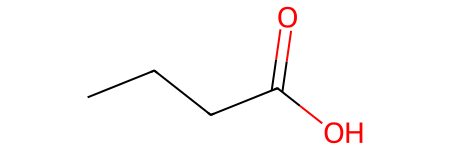

In [32]:
Test_SMILES = 'CCCC(=O)O'
Expected_odors = 'fruity, sour, dairy, sharp, cheesy, buttery'

mol = Chem.MolFromSmiles(Test_SMILES)
mol

We select the GraphFeaturizer() to featurize the SMILES and use the model to get predictions. Then we plot a bar graph to see the top 10 predicted odors for the SMILES.

<Axes: xlabel='odors'>

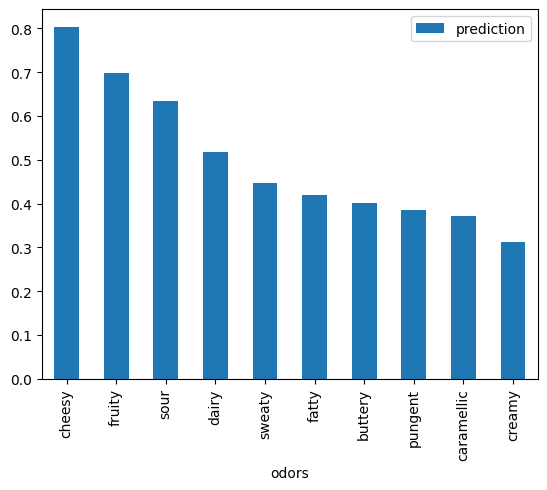

In [33]:
# Featuize test smiles
featurizer = GraphFeaturizer()
featurized_data = featurizer.featurize(Test_SMILES)

# Get predictions from trained model
prediction = model.predict(dc.data.NumpyDataset(featurized_data))

# Visualize the top 10 predictions
prediction_df = pd.DataFrame({'odors': TASKS, 'prediction': prediction.squeeze()}).sort_values(by='prediction', ascending=False)
prediction_df[:10].plot.bar(x='odors', y='prediction')

## Visualizing Perceptual Odor Space <a class="anchor" id="visualize"></a>
Now we will plot Kernel Density Estimations of select odor categories in a reduced space of embeddings from the Penultimate layer (Principal Odor Map) of the model.

We use the trained model to predict embeddings for the dataset. Then we apply PCA to reduce the dimensionality of the embeddings to 2 components. Next we compute KDE for different labels in the dataset (either based on true values or predicted values) and plot contours in the reduced 2D space.

In [34]:
def pom_plot(model, dataset, is_preds=False):
   pom_embeds = model.predict_embedding(dataset)
   required_desc = list(dataset.tasks)


   # Define type dictionaries for odor categories to be visualized
   type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
   type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
   type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
  
   # Perform Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings to 2 components
   pca = PCA(n_components=2, iterated_power=10)
   reduced_features = pca.fit_transform(pom_embeds)


   # Get the variance explained by the first two principal components
   variance_explained = pca.explained_variance_ratio_
   variance_pc1 = variance_explained[0]
   variance_pc2 = variance_explained[1]


   # If is_preds is True, use the model to make predictions on the dataset
   if is_preds:
       y_preds = model.predict(dataset)
       # Set a threshold for predictions
       threshold = np.percentile(y_preds, 95, axis=0)
       y = (y_preds >= threshold).astype(int)
   else:
       # Otherwise, use the true labels from the dataset
       y = dataset.y


   # Define a grid of points for Kernel Density Estimation (KDE)
   x_grid, y_grid = np.meshgrid(np.linspace(reduced_features[:, 0].min(), reduced_features[:, 0].max(), 500),
                                np.linspace(reduced_features[:, 1].min(), reduced_features[:, 1].max(), 500))
   grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])


   # Define a function to get KDE values for a specific label
   def get_kde_values(label):
       plot_idx = required_desc.index(label)
       label_indices = np.where(y[:, plot_idx] == 1)[0]
       kde_label = gaussian_kde(reduced_features[label_indices].T)
       kde_values_label = kde_label(grid_points)
       kde_values_label = kde_values_label.reshape(x_grid.shape)
       return kde_values_label
  
   # Define a function to plot contours for a given type dictionary
   def plot_contours(type_dictionary, bbox_to_anchor):
       main_label = list(type_dictionary.keys())[0]
       plt.contourf(x_grid, y_grid, get_kde_values(main_label), levels=1, colors=['#00000000',type_dictionary[main_label],type_dictionary[main_label]])
       legend_elements = []
       for label, color in type_dictionary['subs'].items():
           plt.contour(x_grid, y_grid, get_kde_values(label), levels=1, colors=color, linewidths=2)
           legend_elements.append(Patch(facecolor=color, label=label))
       legend = plt.legend(handles=legend_elements, title=main_label, bbox_to_anchor=bbox_to_anchor)
       legend.get_frame().set_facecolor(type_dictionary[main_label])
       plt.gca().add_artist(legend)


   # Create a figure and plot contours for different types
   plt.figure(figsize=(15, 10))
   plt.title('KDE Density Estimation with Contours in Reduced Space')
   plt.xlabel(f'Principal Component 1 ({round(variance_pc1*100, ndigits=2)}%)')
   plt.ylabel(f'Principal Component 2 ({round(variance_pc2*100, ndigits=2)}%)')
   plot_contours(type_dictionary=type1, bbox_to_anchor = (0.2, 0.8))
   plot_contours(type_dictionary=type2, bbox_to_anchor = (0.9, 0.4))
   plot_contours(type_dictionary=type3, bbox_to_anchor = (0.3, 0.1))


   # Display the plot
   plt.show()
   plt.close()

The plotted contours are color-coded based on different categories and their subcategories. Regions abundant with molecules broadly categorized as floral, meaty, or alcoholic are shaded, while regions abundant with more specific category labels (like: lavender, roasted etc.) are outlined.

KDE contour plot for true labels (true perceptual odor space)

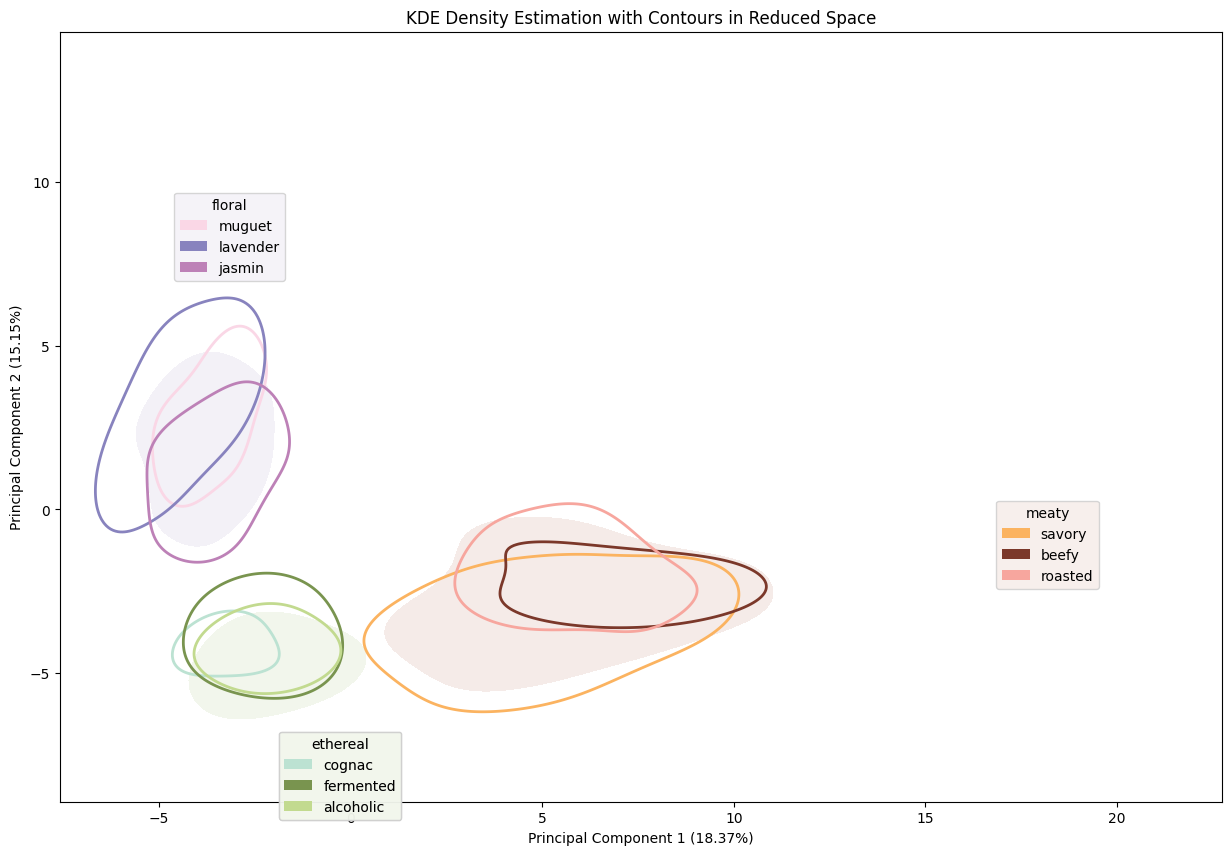

In [35]:
pom_plot(model, dataset, is_preds=False)

KDE contour plot for predicted labels (predicted perceptual odor space)
Note how closely it resembles the true perceptual odor space.

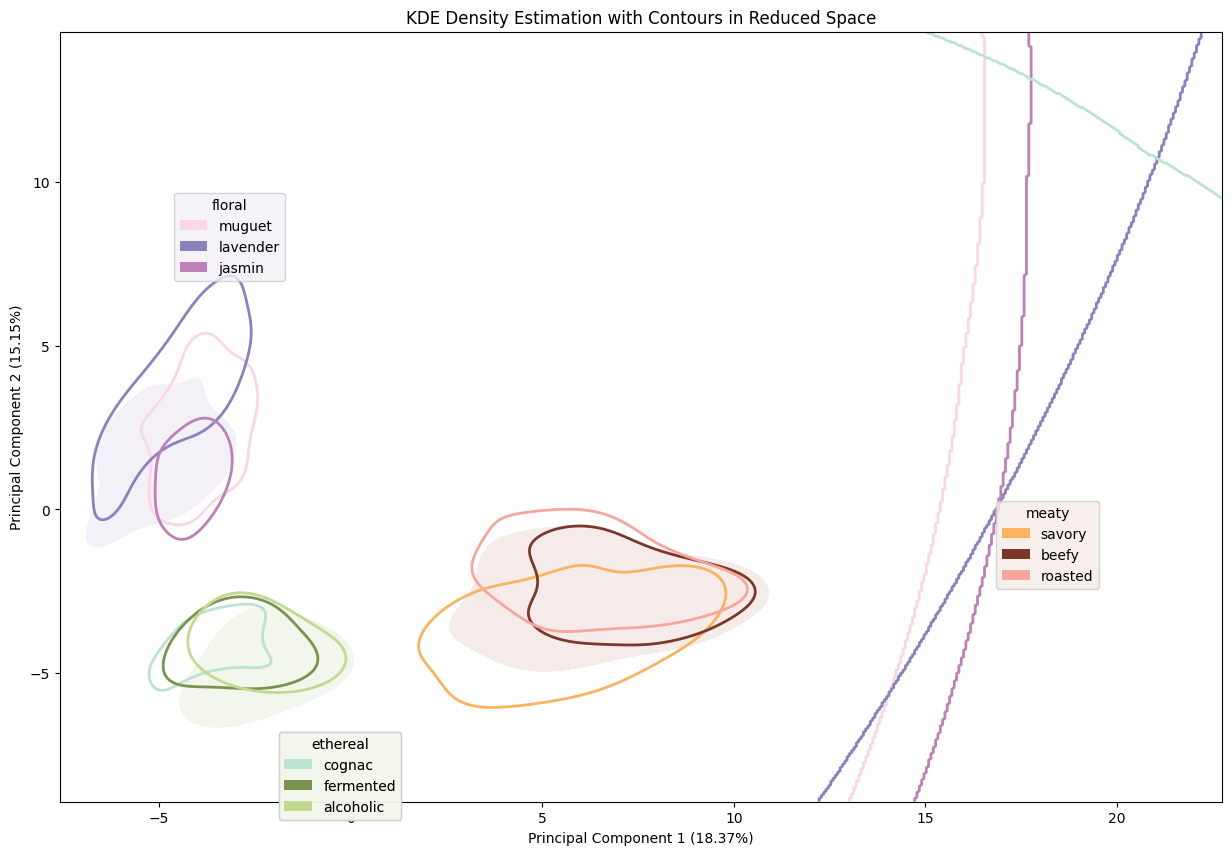

In [36]:
pom_plot(model, dataset, is_preds=True)

## Citing This Tutorial <a class="anchor" id="cite"></a>

This tutorial was contributed to Deepchem by:

In [ ]:
@manual{Olfaction,
title={Predict Multi-Label Odor Descriptors using OpenPOM},
organization={OpenPOM},
author={Aryan Amit Barsainyan, Ritesh Kumar, Pinaki Saha, Michael Schmuker},
howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Predict_Multi_Label_Odor_Descriptors_using_OpenPOM.ipynb}},
year={2023},
}